In [1]:
# from google.colab import auth
# from googleapiclient.discovery import build

import io
# from googleapiclient.http import MediaIoBaseDownload

import pandas as pd

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#Graficos
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

### Cargando data frame

In [2]:
path= "../data/hotels_train.csv"
df = pd.read_csv(path)

## **Vista General**
Copiamos el dataFrame para no realizar cambios en el original y damos una vista general a los datos.

In [3]:
df_hotel=df.copy()
df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61913 entries, 0 to 61912
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           61913 non-null  object 
 1   lead_time                       61913 non-null  int64  
 2   arrival_date_year               61913 non-null  int64  
 3   arrival_date_month              61913 non-null  object 
 4   arrival_date_week_number        61913 non-null  int64  
 5   arrival_date_day_of_month       61913 non-null  int64  
 6   stays_in_weekend_nights         61913 non-null  int64  
 7   stays_in_week_nights            61913 non-null  int64  
 8   adults                          61913 non-null  int64  
 9   children                        61909 non-null  float64
 10  babies                          61913 non-null  int64  
 11  meal                            61913 non-null  object 
 12  country                         

## Vemos las primeras filas de datos

In [4]:
df_hotel.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,9.0,NaN,0,Transient,115.5,0,1,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,NaN,0,Transient,42.0,1,0,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,9.0,NaN,0,Transient,229.0,0,2,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,154.0,NaN,0,Transient,75.0,0,0,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,20.0,NaN,0,Transient-Party,75.0,0,1,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0


In [5]:
df.iloc[:, 27:]

,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled
0,0,1,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,1,0,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,0,2,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,0,0,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,0,1,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0
...,...,...,...,...,...
61908,0,1,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1
61909,0,0,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0
61910,0,0,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0
61911,0,0,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1


Con la información de los primeros 5 registros y a través del método info del dataset vamos a hacer un resumen de cómo se clasifican las columnas y las agruparemos:

- Reserved y assigned room type pueden diferir debido a overbooking del hotel o por pedido del cliente. Se presenta en forma de letras para más seguridad.
- Meal corresponde al tipo de comida que ofrece la reserva y se dividen en: Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner)
- Market Segment y Distribution Channel tienen las mismas categorias: “TA” means “Travel Agents” and “TO” means “Tour Operators”
- Deposit Type se refiere a si el cliente realizó algún tipo de depósito para garantizar la reserva: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.


In [6]:
categoricas = ['hotel', 'arrival_date_month', 'customer_type', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 
               'deposit_type', 'agent'] 
#ID y company nos es irrelevante ya que no nos brinda información, es un dato que le sirve a la empresa, lo mismo con agente? es categórica porque no representa valor numérico de verdad
numericas = ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 
         'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes, days_in_waiting_list', 'adr', 'required_car_parking_spaces',
        'total_of_special_requests'] 
#Se podria validar que en babies no haya valores raros, esta como float pero tiene que ser entero
#Se puede crear una nueva variable que tome las previas cancelaciones y las que no para hacer como un puntaje del pasajero mmm more likely to cancel?
             


### Valores nulos

Limpieza de datos, Veamos la cantidad de valores nulos que posee cada variable para considerar en sus analisis siguientes.

In [7]:
print(df_hotel.isna().sum())

hotel                                 0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                             221
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              7890
company                           58761
days_in_waiting_list                  0


In [8]:
def print_null_count(data: pd.DataFrame):
  null_series = data.isna().sum()
  type_count_df = pd.DataFrame({
    "Columnas": null_series.index,
    "valores_nulos": null_series.values,
    "porcentaje": null_series.values / data.shape[0],

  })
  type_count_df = type_count_df[type_count_df["valores_nulos"] > 0].sort_values("valores_nulos", ascending=False)
  px.bar(
    type_count_df,
    x="Columnas",
    y="porcentaje",
    hover_data={"valores_nulos": ":.0f", "porcentaje":":.2r"},
    title="Porcentaje de valores nulos por columna"
  ).show()

print_null_count(df_hotel)

podemos notar que existen 4 variables que poseen datos nulos, teniendo en cuenta que el dataframe contiene un total de 61913 datos
- children con 4 representa el 0,006% del dataframe
- country con 221 representa el 0,35% 
- agent con 7890 represnta el 12,7%
- company con 58761 representa el 94,9%

Se decide eliminar las filas (datos) que tiene tienen valores nulos en las columnas **country** y **children** dado que su porcentaje es infimo con respecto a la cantidad total de datos.(?? no se realizo la eliminacion)


In [9]:
df_filtered_country = df_hotel[df_hotel['country'].isna()]
df_hotel= df_hotel.drop(df_filtered_country.index)

In [10]:
df_filtered_children = df_hotel[df_hotel['children'].isna()]
df_hotel.drop(df_filtered_children.index, inplace=True)
print(df_hotel.isna().sum())

hotel                                 0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                               0
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              7744
company                           58608
days_in_waiting_list                  0


Se analiza los valores no nulos de la columna **company** y no se encuentra informacion util por lo que se decide eliminar toda la columna dada la gran cantidad de valores nulos (95%) y no es de ayuda para obtener el target.

In [11]:
df_hotel.drop(columns="company", inplace=True)
df_hotel.columns

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date', 'id', 'is_canceled'],
      dtype='object')

### Variables Categoricas

Veamos como se comportan las variables categoricas con respecto a su estado de reserva. Teniendo en cuenta lo recien visto

In [12]:
def print_categorical_value_count(data: pd.DataFrame, column: str, subdivision: str):
  categorical_column_info = pd.merge(
    data.groupby(column)[subdivision].value_counts().reset_index(name="Cantidad"),
    data[column].value_counts().reset_index(name="total").rename(columns={"index": column}),
    on=column,
  ).sort_values(["total", subdivision], ascending=False)
  categorical_column_info["percentage"] = categorical_column_info["Cantidad"] / categorical_column_info["total"]
  categorical_column_info[subdivision] = categorical_column_info[subdivision].astype(str)
  px.bar(
    categorical_column_info,
    x=column,
    y="Cantidad",
    color=subdivision,
    hover_data={"percentage":":.2r"},
    barmode='group',
    title= "Distribución de varible " + column + " vs is_Canceled"
  ).show()

categorical_cols = [
  'hotel',
  'arrival_date_month',
  'meal',
  'country',
  'market_segment', # market_segment tiene info casi identica a distribution_channel
  'distribution_channel',
  'reserved_room_type',
  'assigned_room_type',
  'deposit_type',
  'customer_type',
  "agent", # marcado como categorica en el paper (agent id)
  "is_repeated_guest", # marcado como categorica en el paper (true false value)
  "arrival_date_day_of_month", # dia del mes (lo veo como una categoria de 31 valores posibles)
  'arrival_date_week_number', # week number (lo veo como una categoria de 53 valores posible)
  # "company", # marcado como categorica en el paper (company id) se borro del df
  
]
  # arrival_date_month + arrival_date_day_of_month me parece que tienen la misma info
  # arrival_date_week_number con diferente granularidad

for cat in categorical_cols:
  print_categorical_value_count(df_hotel, cat, "is_canceled")


### Variables numericas

Veamos si existen varibles negativas que no tengan sentido

In [13]:
num_cols = [
  'lead_time',
  'arrival_date_year',
  'stays_in_weekend_nights',
  'stays_in_week_nights',
  'adults',
  'children',
  'babies',
  'previous_cancellations',
  'previous_bookings_not_canceled',
  'booking_changes',
  'days_in_waiting_list',
  'adr',
  'required_car_parking_spaces',
  'total_of_special_requests'
]

for col in num_cols:
    values_list = df_hotel[df_hotel[col]<0][col]
    print("Cantindad de valores negativos de",col + ":" , values_list.size)

Cantindad de valores negativos de lead_time: 0
Cantindad de valores negativos de arrival_date_year: 0
Cantindad de valores negativos de stays_in_weekend_nights: 0
Cantindad de valores negativos de stays_in_week_nights: 0
Cantindad de valores negativos de adults: 0
Cantindad de valores negativos de children: 0
Cantindad de valores negativos de babies: 0
Cantindad de valores negativos de previous_cancellations: 0
Cantindad de valores negativos de previous_bookings_not_canceled: 0
Cantindad de valores negativos de booking_changes: 0
Cantindad de valores negativos de days_in_waiting_list: 0
Cantindad de valores negativos de adr: 1
Cantindad de valores negativos de required_car_parking_spaces: 0
Cantindad de valores negativos de total_of_special_requests: 0


Podemos observar un valor negativo para la varible adr (Tarifa media diaria definida), no puede existir una tarifa negativa ya que es un monto postivo a cobrar por el hotel, pasaremos a eliminar ese dato ya que es uno solo 

In [14]:
df_hotel.drop(df_hotel[df_hotel['adr'] < 0].index, inplace=True)
df_hotel[df_hotel['adr']<0]

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled


observemos como se comportan las variables numericas.

In [15]:
df_numeric = df_hotel[num_cols]
df_numeric.describe()

,lead_time,arrival_date_year,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,61687.000000,61687.000000,61687.000000,61687.000000,61687.000000,61687.000000,61687.000000,61687.000000,61687.000000,61687.000000,61687.000000,61687.000000,61687.000000,61687.000000
mean,112.508908,2016.155851,0.925349,2.511372,1.864347,0.105241,0.007181,0.114822,0.111531,0.195941,2.648646,102.535640,0.049459,0.523725
std,110.742358,0.708282,0.993145,1.885127,0.588541,0.403491,0.092326,0.995351,1.389365,0.610867,18.652482,47.707009,0.220018,0.775093
min,0.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,2016.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000
50%,78.000000,2016.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000
75%,172.000000,2017.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,629.000000,2017.000000,16.000000,40.000000,55.000000,10.000000,9.000000,26.000000,70.000000,17.000000,391.000000,510.000000,8.000000,5.000000


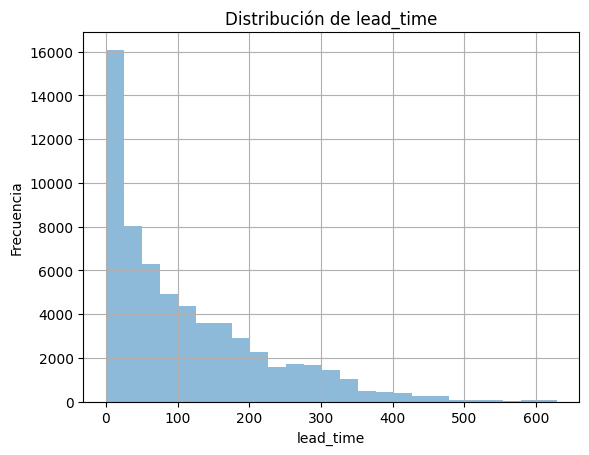

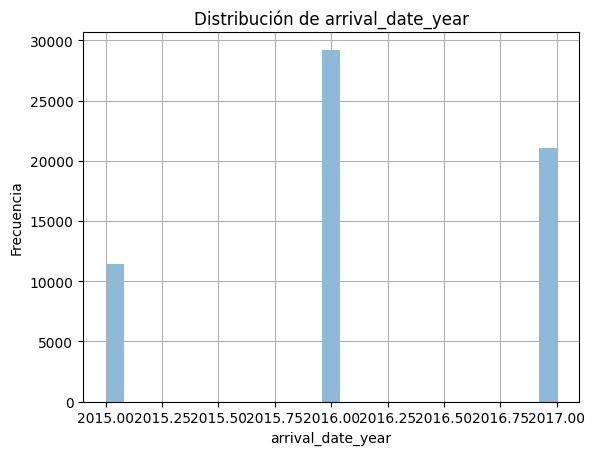

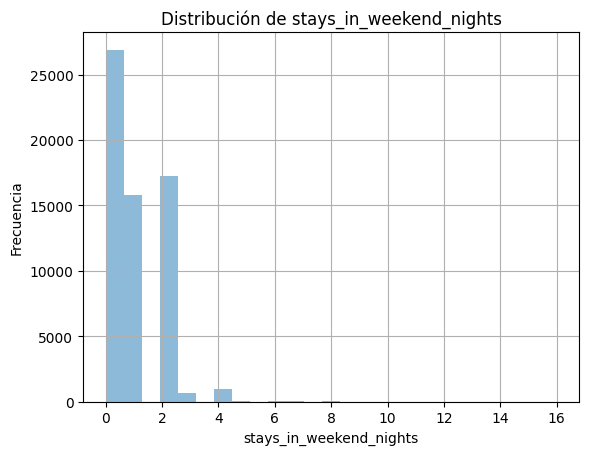

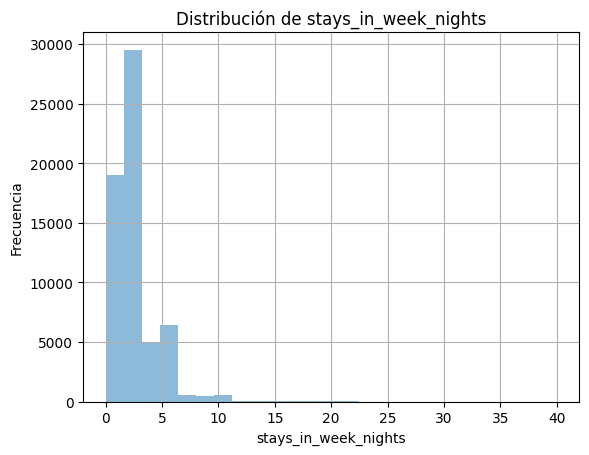

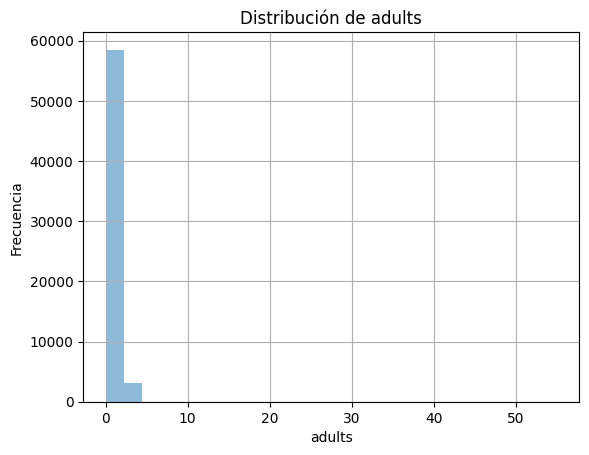

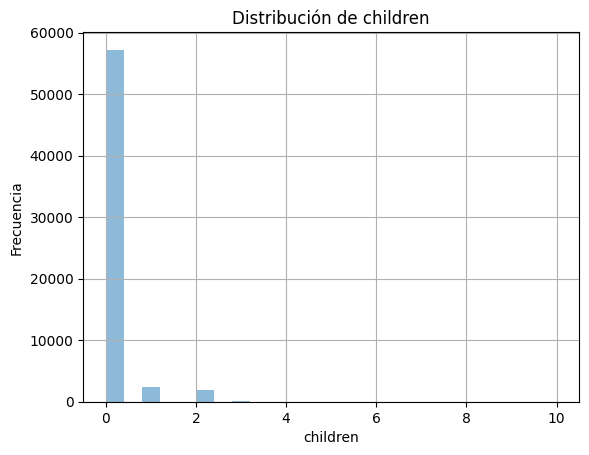

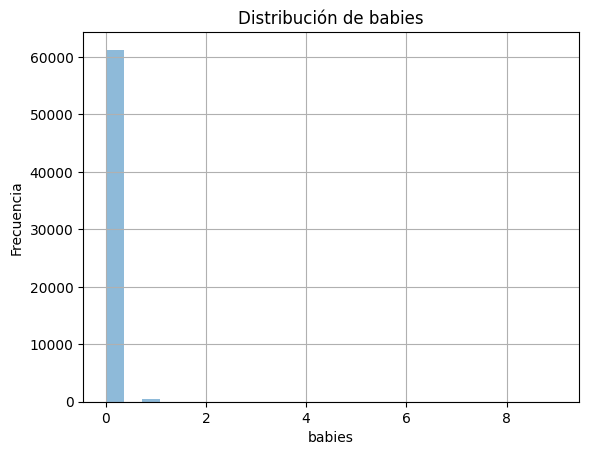

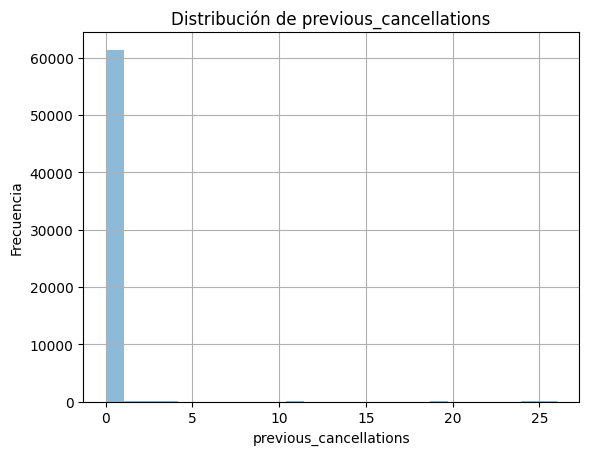

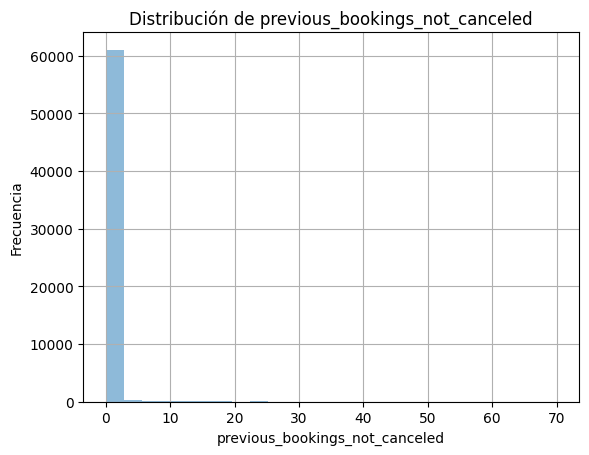

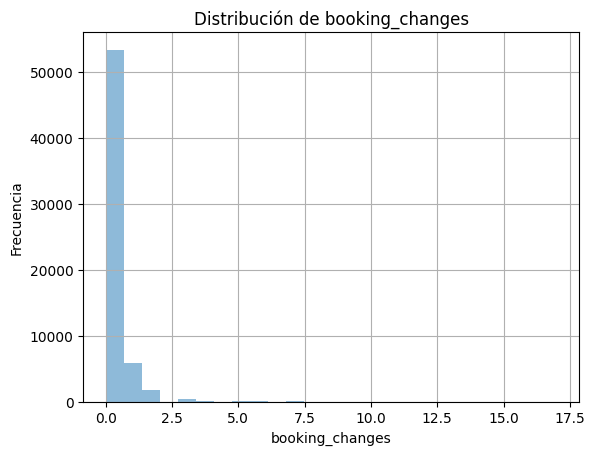

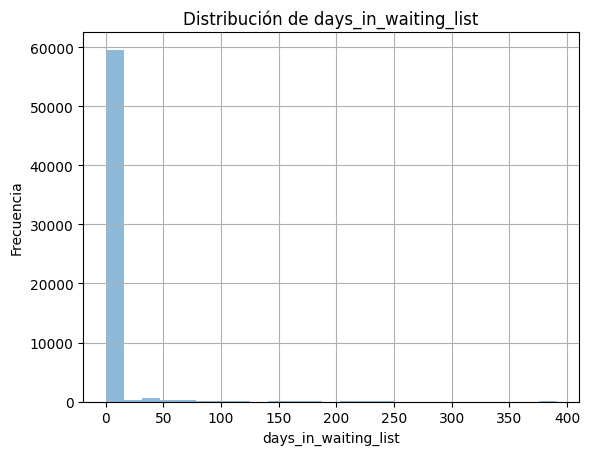

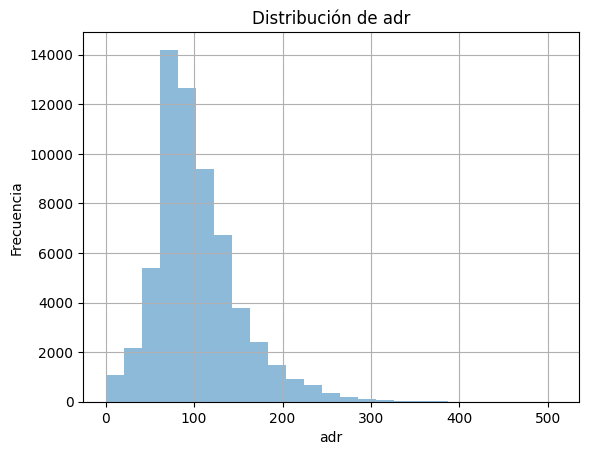

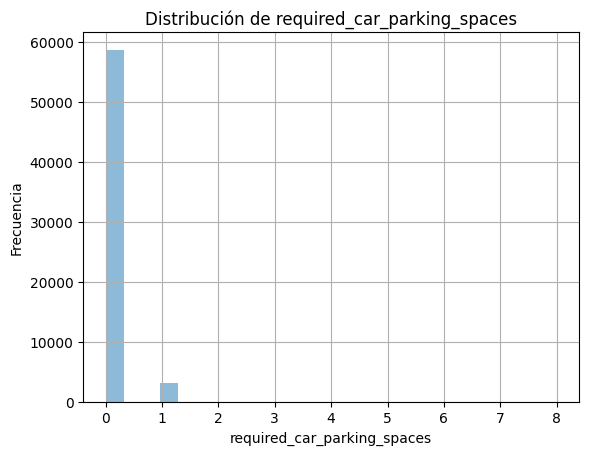

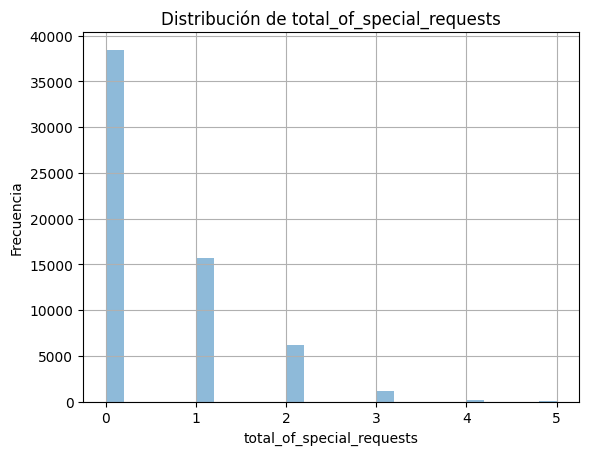

In [16]:
for column in num_cols:
  plt.title('Distribución de ' + column)
  plt.hist(df_hotel[column], bins = 25 , alpha = 0.5)
  plt.xlabel(column)
  plt.ylabel("Frecuencia")
  plt.grid(True)
  plt.show()
  # px.histogram(df_hotel, x=column, title = "Distribución de " + column ).show()
    # sns.histplot(data=df_hotel[column], alpha = 0.5).set(title="Distribución de " + column ,xlabel=column,ylabel="Frecuencia")
    # df_hotel[column].plot.box(title="Boxplot variable Age",xlabel=" ",ylabel=column)

## Martriz Correlacion
veamos si existe una posible correlacion entre las variables.

<Axes: >

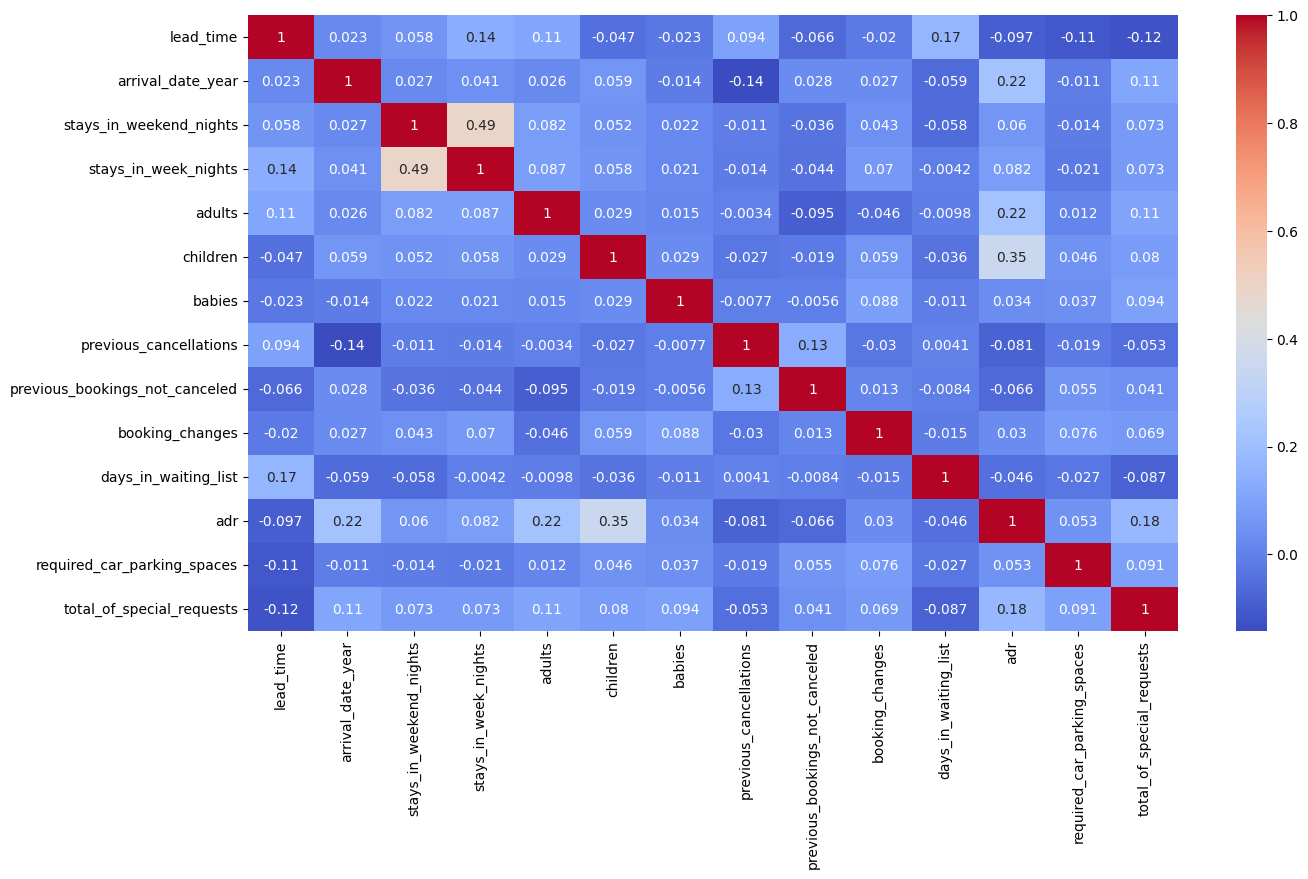

In [17]:
num_df = df_hotel.filter(items=num_cols)
num_dfCorr = num_df.corr()

#Grafico la matriz de correlación en un Heatmap
plt.figure(figsize = (15,8))
sns.heatmap(num_dfCorr, annot = True, cmap='coolwarm')

Podemos observar una correlacion media alta entre las variables: 
- stays_in_week_nights vs stays_in_weekend_nights (0.49)
- adr vs children (0.35)

Analicemos estas variables.

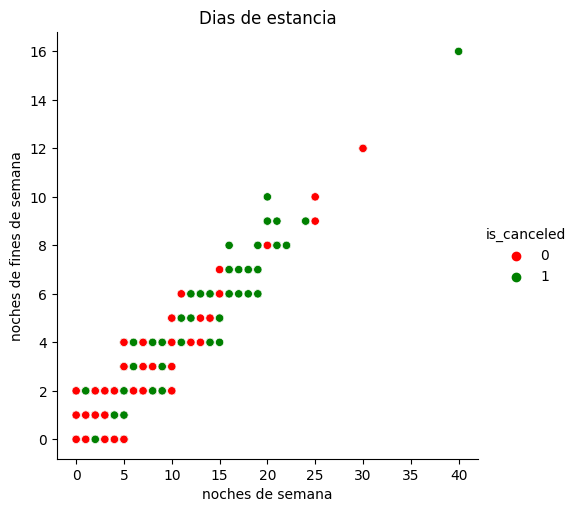

In [18]:
# Gráfico
sns.relplot(data=df_hotel,x="stays_in_week_nights", y="stays_in_weekend_nights", hue="is_canceled",
palette=["r", "g"]).set(title="Dias de estancia",xlabel='noches de semana',ylabel='noches de fines de semana')


[Text(0.5, 1.0, 'Distribucion'),
 Text(0.5, 0, 'Cantidad de Niños'),
 Text(0, 0.5, 'Tarifa media diaria definida')]

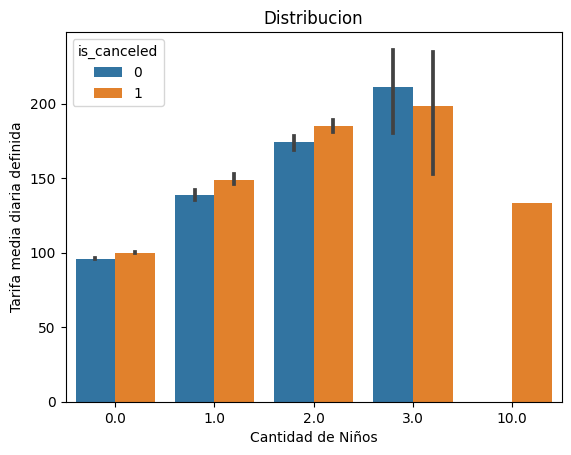

In [19]:
#sns.relplot(data = df_hotel, x = 'adr', y = 'children', hue = 'is_canceled', 
#palette=["r", "g"]).set(title="Distribucion de datos",xlabel='Tarifa media diaria definida',ylabel='niños')

sns.barplot(data=df_hotel, x="children", y="adr", hue="is_canceled").set(title="Distribucion",xlabel='Cantidad de Niños',ylabel='Tarifa media diaria definida')

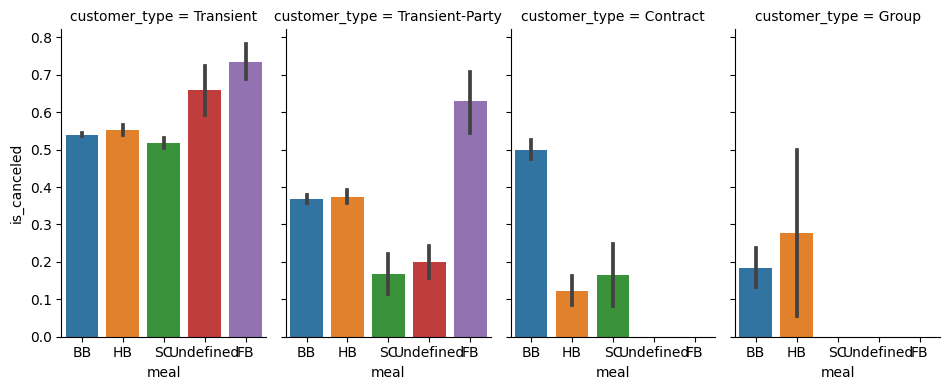

In [20]:
sns.catplot(
    data=df_hotel, x="meal", y="is_canceled", col="customer_type",
    kind="bar", height=4, aspect=.6,
)

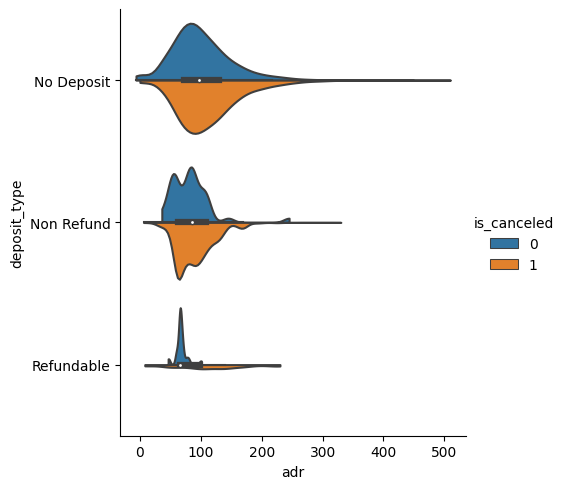

In [21]:
sns.catplot(
    data=df, x="adr", y="deposit_type", hue="is_canceled",
    kind="violin", bw=.25, cut=0, split=True,
)

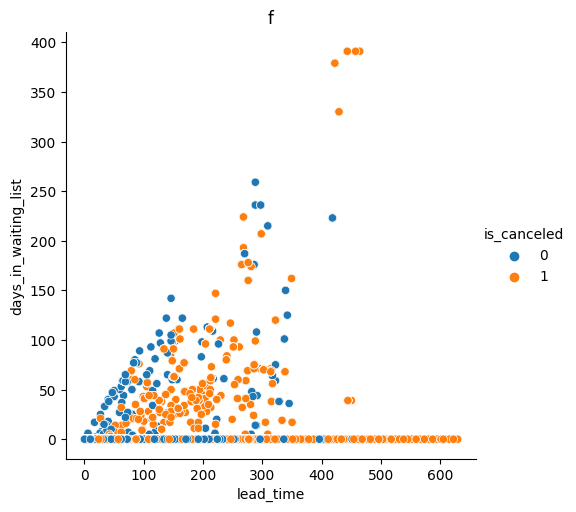

In [22]:
#Dispersograma con Seaborn

graf_relplot=sns.relplot(data=df_hotel,x="lead_time", y="days_in_waiting_list", hue="is_canceled").set(title="f",xlabel='lead_time',ylabel='days_in_waiting_list')


## Datos Faltantes
Para los valores nulos de la columna **agent** se eligio utilizar K-Nearest Neighbors para asignarles el valor mas probable.
Como se puede ver la cantidad de ids se mantuvo (no tendria sentido que se inventen nuevos ids)
Y los valores se mantienen en la misma proporcion que antes del cambio


In [23]:
def fill_null_with_knn(data: pd.DataFrame, column: str):
  num_cols = [
    'lead_time',
    'arrival_date_year',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'days_in_waiting_list',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests'
  ]
  num_df = data.filter(num_cols)
  # se normaliza las columnas numericas para evitar que los valores mas grandes tengan mayor peso
  num_normalized_df = pd.DataFrame(MinMaxScaler().fit_transform(num_df), columns=num_df.columns)
  # se agregaron algunas columnas categoricas utlizando one hot encoding
  hot_encoded_cols = pd.get_dummies(data[["hotel", "meal", "deposit_type", "customer_type"]], drop_first=True)
  knn_df = pd.concat([
      num_normalized_df,
      hot_encoded_cols,
      data[column]
    ],
    axis=1
  )
  # TODO: Mejorable utilizar una implementacion que permita el uso de mas neighbors con moda
  imputer = KNNImputer(n_neighbors=1)
  df_hotel[column] = pd.DataFrame(imputer.fit_transform(knn_df), columns=knn_df.columns)[column]

print(f"Cantidad de ids unicos en la columna agent antes de la transformacion: {df_hotel.agent.nunique()}")
print_categorical_value_count(df_hotel, "agent", "is_canceled")

fill_null_with_knn(df_hotel, "agent")

print(f"Cantidad de ids unicos en la columna agent despues de la transformacion: {df_hotel.agent.nunique()}")
print_categorical_value_count(df_hotel, "agent", "is_canceled")

Cantidad de ids unicos en la columna agent antes de la transformacion: 296


Cantidad de ids unicos en la columna agent despues de la transformacion: 296


### Casos sin Logica
veamos si hay existen casos que no tienen logica.

In [24]:
categorical_df= df_hotel.filter(items=categorical_cols)
categorical_df.columns

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'agent', 'is_repeated_guest',
       'arrival_date_day_of_month', 'arrival_date_week_number'],
      dtype='object')

**Existen niños registrados sin adultos?**

[Text(0.5, 1.0, 'Distribucion de Niños y adultos'),
 Text(0.5, 0, 'Cantidad de Niños'),
 Text(0, 0.5, 'Cantidad de Adultos')]

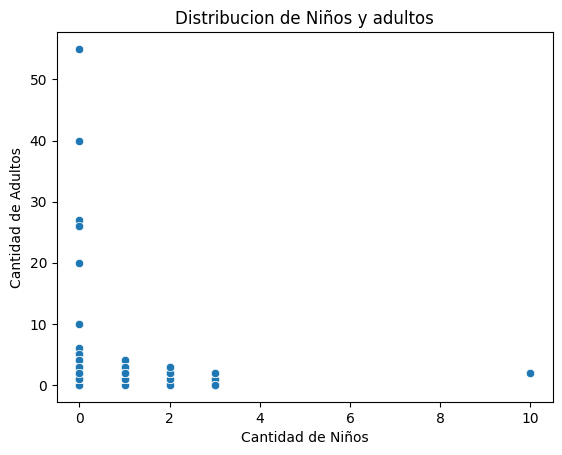

In [25]:
sns.scatterplot(data=df_hotel, x="children", y= 'adults').set(title="Distribucion de Niños y adultos",xlabel='Cantidad de Niños',ylabel='Cantidad de Adultos')

[Text(0.5, 1.0, 'Distribucion de Bebes y adultos'),
 Text(0.5, 0, 'Cantidad de Bebes'),
 Text(0, 0.5, 'Cantidad de Adultos')]

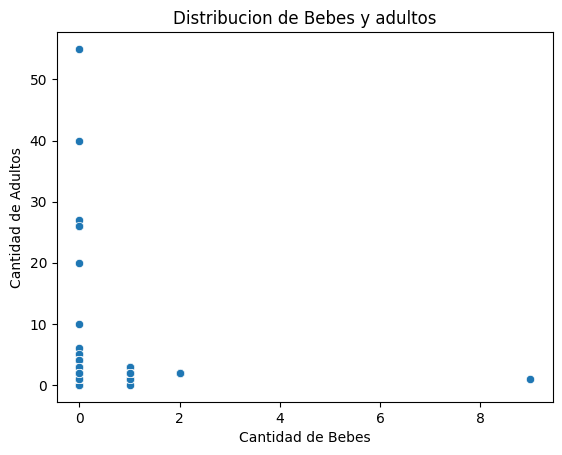

In [26]:
sns.scatterplot(data=df_hotel, x="babies", y= 'adults').set(title="Distribucion de Bebes y adultos",xlabel='Cantidad de Bebes',ylabel='Cantidad de Adultos')

podemos ver que existen niños registrados sin adultos a cargo, veamos la cantidad de datos que hay con respecto al total del dataframe

In [27]:
sin_adultos = df_hotel[df_hotel['adults'] == 0]
sin_adultos_y_con_ninios =sin_adultos[(sin_adultos['children'] > 0) | (sin_adultos['babies'] > 0 )]
sin_adultos_y_con_ninios['children'].count()

121

In [28]:
df_hotel['children'].count()

61687

podemos ver que hay 121 datos en donde hay niños registrados sin adultos y al representar el 0,196% del total del dataframe que es 61687, se decide a eliminar esos datos.

In [29]:
df_hotel.drop(sin_adultos_y_con_ninios.index, inplace=True)
df_hotel['children'].count()

61566

Se busca reservas que no tengan estadia en dia de semana ni en fin de semana y como son menores al 0.5% se las elimina

In [30]:
reservas_sin_estadia = df_hotel[(df_hotel["stays_in_week_nights"] == 0) & (df_hotel["stays_in_weekend_nights"] == 0)]
print(f"Reservas sin estadia: {reservas_sin_estadia.shape[0]}")
df_hotel.drop(reservas_sin_estadia.index, inplace=True)

Reservas sin estadia: 293


Veamos el grafico del **Tipo de Deposito** en donde podiamos ver que si es **No reembolsable** hay mas probabilidad de ser cancelado

[Text(0.5, 1.0, 'Grafico de Tipos de Depositos'),
 Text(0.5, 0, 'Tipos de Deposito'),
 Text(0, 0.5, 'Cantidad')]

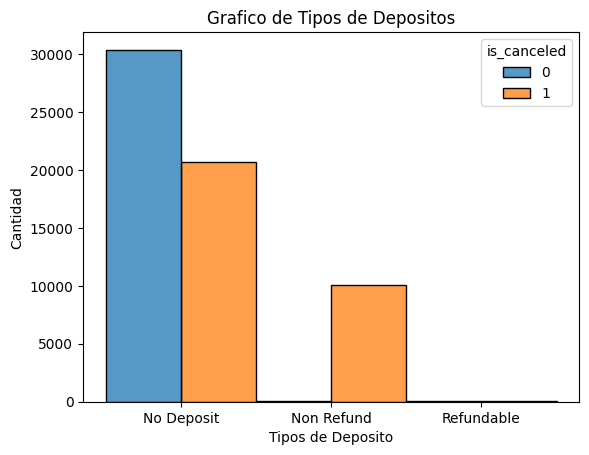

In [31]:
sns.histplot(data=df_hotel, x='deposit_type', hue='is_canceled', multiple="dodge").set(title="Grafico de Tipos de Depositos",xlabel='Tipos de Deposito',ylabel='Cantidad')

analicemos los casos en donde no hay reembolso

In [32]:
non_refunds = df_hotel[df_hotel['deposit_type']=='Non Refund']
non_refunds_canceled = non_refunds[non_refunds['is_canceled'] == 1]
non_refunds_canceled.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,is_canceled
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,Non Refund,154.0,0,Transient,75.0,0,0,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
16,City Hotel,333,2016,September,39,20,0,2,2,0.0,...,Non Refund,58.0,19,Transient,90.0,0,0,2015-11-11,95c27727-6b56-497b-ae24-cb41c5081313,1
22,City Hotel,374,2015,October,44,26,1,1,2,0.0,...,Non Refund,1.0,0,Contract,62.0,0,0,2015-01-01,ec5c0487-3158-45c2-b755-3498eb775b46,1
28,City Hotel,166,2016,November,45,1,0,3,1,0.0,...,Non Refund,236.0,0,Transient,110.0,0,0,2016-07-13,30b89e48-3603-4947-88d7-ea6b0ace0e9a,1
29,City Hotel,396,2017,April,17,25,0,1,2,0.0,...,Non Refund,229.0,0,Transient,90.0,0,0,2016-04-17,1f0b411b-9ade-4dab-b601-fb360731602a,1


[Text(0.5, 1.0, 'Grafico de Tipos de Depositos'),
 Text(0.5, 0, 'Tipos de Deposito'),
 Text(0, 0.5, 'Cantidad')]

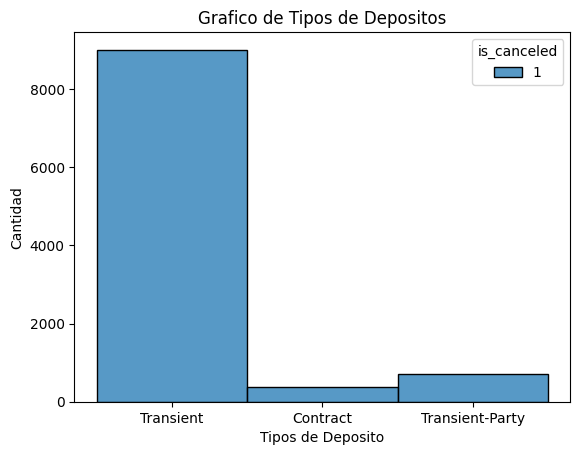

In [33]:
sns.histplot(data=non_refunds_canceled, x='customer_type', hue='is_canceled', multiple="dodge").set(title="Grafico de Tipos de Depositos",xlabel='Tipos de Deposito',ylabel='Cantidad')

se podria decir que si el tipo de cliente es transitorio y es no reembolsable es mas probable que se cancele la reserva?